In [1]:
#!pip install transformers
#!pip install sentencepiece
#!pip install wrapt --upgrade --ignore-installed
#!pip install tensorflow
#!pip install pydot
#!pip install pydotplus
#!sudo apt-get install graphviz
#!pip install keras
#!pip install focal_loss

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#import zipfile
#with zipfile.ZipFile("./drive/MyDrive/HSE DS data/model2.zip", "r") as zip_ref:
#    zip_ref.extractall("./data")

In [4]:
import tensorflow as tf
tf.__version__

2022-11-19 19:23:25.865214: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-19 19:23:25.865329: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.4.1'

In [5]:
import re
import string
import os
import gc
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm # progress bar
from sklearn.model_selection import train_test_split
# from nltk.corpus import stopwords 
# from spacy.lang.da.stop_words import STOP_WORDS as da_stop
# from spacy.lang.de.stop_words import STOP_WORDS as de_stop
# from spacy.lang.es.stop_words import STOP_WORDS as es_stop
# from spacy.lang.it.stop_words import STOP_WORDS as it_stop
# from spacy.lang.nl.stop_words import STOP_WORDS as nl_stop
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import model_to_dot

import transformers
from transformers import AutoTokenizer, TFAutoModel
print (transformers.__version__)
from IPython.display import SVG
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelEncoder

4.5.1


#### TPU configuration

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)  #asa era original
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() #asa era default
#     strategy=tf.distribute.MirroredStrategy() #pentru mai multe gpu

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.0.0.2:8470']


2022-11-19 19:23:34.657464: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-19 19:23:34.661405: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-19 19:23:34.661447: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-19 19:23:34.661477: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4b9c0068bf71): /proc/driver/nvidia/version does not exist
2022-11-19 19:23:34.665375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


#### Load data

Clean text from https://tazkianida.medium.com/natural-language-processing-find-the-most-common-phrases-on-twitter-1bd17f1941cf

# Partea de clean text mutata

In [7]:
# def clean_text_med(data):
#     #remove user, https, and RT
#     data['Text'] = np.vectorize(remove_pattern)(data['text'], "(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)")
#     #remove punctuations
#     data['Text'] = data['Text'].str.replace("[^a-zA-Z#]", " ")
#     #lowering string
#     data['Text'] = data['Text'].str.lower()
#     #remove stop words
#     stop_words = set(stopwords.words('dansk')) |set(stopwords.words('Deutsch'))|set(stopwords.words('español'))|set(stopwords.words('italiano'))|set(stopwords.words('Nederlands'))
#     data['Text'] = [' '.join([w for w in x.lower().split() if w not in stop_words]) 
#     for x in data['Text'].tolist()]
#     #remove words with len < 2
#     data['Text'] = data['Text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

Clean text

In [8]:
def clean_text(text,sw):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https?:\/\/\S+', '', text)
#     text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)+', '', text) #matches other 
    #special for iloc[32827]
    text = text.replace('\\t', '')
    text = text.replace('_blank', '')
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text) #maybe not? la laborator - poate au sens?
    #remove stopwords from nltk
    words = [word for word in text.split() if word.lower() not in sw]
    text=" ".join(words)
    
    return text

In [9]:
def clean_text_tran(text):
    # to lower case
#     text = text.lower()
    # remove links
    text = re.sub('https?:\/\/\S+', '', text)
#     text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)+', '', text) #matches other 
    #special for iloc[32827]
    text = text.replace('\\t', '')
    text = text.replace('_blank', '')
    # remove punctuation
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
#     text = re.sub('\w*\d\w*', '', text) #maybe not? la laborator - poate au sens?
    #remove stopwords from nltk
#     words = [word for word in text.split() if word.lower() not in sw]
#     text=" ".join(words)
    
    return text

In [10]:
# import sys
# from io import StringIO
# import pandas as pd


# old_stderr = sys.stderr
# result = StringIO()
# sys.stderr = result

# df = pd.read_csv('../input/datasettranswmicrosoft/german.csv', error_bad_lines=False,index_col=0)

# sys.stderr = old_stderr
# result_string = result.getvalue()
# print(result_string)
# with open('bad_lines.csv', 'w') as bad_lines:
#     for line in result_string.split(r'\n'):
#         bad_lines.write(line)
#         bad_lines.write('\n')
# print('OK')

In [11]:
train_df_unspl = pd.read_csv("../input/unibuccomptranslated/translated_train_data.csv",quotechar="^",index_col="id_ref")

In [12]:
# train_df, validation_df = train_test_split(train_df_unspl, test_size=0.2, random_state=42, stratify=train_df_unspl["language"])
# train_df["label"].loc[train_df["label"]=="England"]=0
# train_df["label"].loc[train_df["label"]=="Ireland"]=1
# train_df["label"].loc[train_df["label"]=="Scotland"]=2
# validation_df["label"].loc[validation_df["label"]=="England"]=0
# validation_df["label"].loc[validation_df["label"]=="Ireland"]=1
# validation_df["label"].loc[validation_df["label"]=="Scotland"]=2
# train_df.drop(columns="language")
# validation_df.drop(columns="language")
# stop_words_plus = stopwords.words('danish')+stopwords.words('german')+stopwords.words('spanish')+stopwords.words('italian')+stopwords.words('dutch')
# stop_words=stopwords.words(fileids=('danish', 'german','spanish','italian','dutch'))+list(da_stop)+list(de_stop)+list(es_stop)+list(it_stop)+list(nl_stop)
# stop_words=stopwords.words(fileids=('danish', 'german','spanish','italian','dutch'))
# print(len(stop_words)==len(stopwords.words(fileids=('danish', 'german','spanish','italian','dutch')))+len(list(da_stop))+len(list(de_stop))+len(list(es_stop))+len(list(it_stop))+len(list(nl_stop)))
# stop_words = set(stopwords.words('danish')) |set(stopwords.words('german'))|set(stopwords.words('spanish'))|set(stopwords.words('italian'))|set(stopwords.words('dutch'))
# print(len(set(stopwords.words('danish')))+len(set(stopwords.words('german')))+len(set(stopwords.words('spanish')))+len(set(stopwords.words('italian')))+len(set(stopwords.words('dutch'))))
# print("fileids",len(stop_words))
# print("plus",len(stop_words_plus))
# print(len(stop_words_plus)==len(stop_words))
# print(len(stop_words)==len(set(stopwords.words('danish')))+len(set(stopwords.words('german')))+len(set(stopwords.words('spanish')))+len(set(stopwords.words('italian')))+len(set(stopwords.words('dutch'))))
# train_df_unspl['Text'] = train_df_unspl.text.apply(lambda x: clean_text_tran(x))
# clean_text_med(train_df_unspl)
le = LabelEncoder()
le.fit(train_df_unspl.label.values.tolist())
print(le.classes_)
target_num = le.transform(train_df_unspl.label.values.tolist())
train_df_unspl['Label']=target_num
# train_df_unspl=train_df_unspl.drop(columns=["language","text","label"])
train_df_unspl=train_df_unspl.drop(columns=["label"])
train_df_unspl=train_df_unspl.dropna()
# train_df, validation_df = train_test_split(train_df_unspl, test_size=0.025, random_state=42) # test_size foarte mic
# train_df, validation_df = train_test_split(train_df_unspl, test_size=0.025, random_state=42, stratify=train_df_unspl["Label"]) # asa am facut stratificarea pana acum???? for some reason da mai bine stratificat dupa Label
train_df, validation_df = train_test_split(train_df_unspl, test_size=0.15, random_state=42, stratify=train_df_unspl["Label"]) #da prost mai prost stratificat dupa langauge??
train_df_unspl=train_df_unspl.drop(columns=["language"])
train_df=train_df.drop(columns=["language"])
print(validation_df.Label.value_counts())
validation_df=validation_df.drop(columns=["language"])
y_confusionmat=validation_df.Label
test_df = pd.read_csv("../input/unibuccomptranslated/clean_test_fixed.csv",quotechar="^",index_col="id_ref")
# test_df['Text']=test_df.text.apply(lambda x: clean_text_tran(x))
# test_df=test_df.drop(columns=["text"])
train_df_unspl.head()

['England' 'Ireland' 'Scotland']
0    3405
1    1580
2    1251
Name: Label, dtype: int64


,Translated,Label
id_ref,,
0,This is an excellent initiative and I fully su...,1
1,"Mr President, I am sure everyone here is aware...",1
2,"Mr President, people in the northern hemispher...",0
3,"Mr President, subject to a few amendments, my ...",0
4,"Mr President, I must protest at the laxity wit...",0


In [13]:
# train_df_unspl = pd.read_csv("../input/compdataset/formatted_train_data.csv")
# le = LabelEncoder()
# le.fit(train_df_unspl.label.values.tolist())
# target_num = le.transform(train_df_unspl.label.values.tolist())
# train_df_unspl['Label']=target_num
# # train_df_unspl=train_df_unspl.drop(columns=["language","label"])
# train_df_unspl=train_df_unspl.drop(columns=["label"])
# # train_df, validation_df = train_test_split(train_df_unspl, test_size=0.025, random_state=42) # test_size foarte mic
# # train_df, validation_df = train_test_split(train_df_unspl, test_size=0.025, random_state=42, stratify=train_df_unspl["Label"]) # asa am facut stratificarea pana acum???? for some reason da mai bine stratificat dupa Label
# train_df, validation_df = train_test_split(train_df_unspl, test_size=0.025, random_state=42, stratify=train_df_unspl["language"]) #da prost???
# print(validation_df.language.value_counts())
# print(train_df.language.value_counts())
# train_df_unspl=train_df_unspl.drop(columns=["language"])
# train_df=train_df.drop(columns=["language"])
# validation_df=validation_df.drop(columns=["language"])

# test_df = pd.read_csv("../input/ub-fmi-cti-2022-2023/test_data.csv")

In [14]:
submission = pd.read_csv("../input/ub-fmi-cti-2022-2023/sample_submission.csv")
len(set(train_df.Label.values))
print("Train size",len(train_df))
print("Validation size",len(validation_df))
print(validation_df.Label.unique())
print(validation_df.Label.value_counts())
# print(validation_df.language.value_counts())
# print(da_stop)
# print(stopwords.words('danish'))
print(train_df_unspl.loc[41569].Translated)
test_df.head()

Train size 35332
Validation size 6236
[0 1 2]
0    3405
1    1580
2    1251
Name: Label, dtype: int64
Imagine if another legislative body in the European Union first took decisions, then offered to publish the minutes and a concise report of the discussion on an internet site. Do you not agree that people would find this an undemocratic and questionable procedure? Is it not time, then, for the Council to finally deliberate in public when it acts as legislator? I am glad that progress has been made, but I still believe that it is completely unacceptable that legislation is still being made in this way in the 21st century.


,Text
id_ref,
0,"Mr President, although we very much sympathise..."
1,I would like to place on record my support for...
2,. The illegal trade in human kidneys has beco...
3,"Mr President, to introduce a note of joy into ..."
4,I voted in favour of granting discharge to the...


### XLM-RoBERTa model

In [15]:
XLMR_MODEL = "roberta-large"
# XLMR_MODEL = "jplu/tf-xlm-roberta-large"
# XLMR_MODEL = "jplu/tf-xlm-roberta-base"
# EPOCHS = 16 #number of epochs in model experimental pentru large, dupa clean test data
# EPOCHS = 19 #number of epochs in model experimental pentru large, la a doua vedere epoca 18 cea mai buna
# EPOCHS = 1 #number of epochs in model default
EPOCHS = 50 #number of epochs in model pentru auto stop

MAX_LEN = 512

SHUFFLE = 2048

LEARNING_RATE = 1e-5

AUTO = tf.data.experimental.AUTOTUNE

# batch size will depend on number of replicas
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # the batch size in each epoch (128)
print(BATCH_SIZE)

128


#### Load XLM-RoBERTa from Hugging Face

In [16]:
tokenizer = AutoTokenizer.from_pretrained(XLMR_MODEL,num_labels=len(set(train_df.Label.values)),output_hidden_states = False)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [17]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(XLMR_MODEL,num_labels=len(set(train_df.Label.values)),output_attentions = False,output_hidden_states = False)

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


CPU times: user 49.6 s, sys: 19.4 s, total: 1min 9s
Wall time: 1min 34s


#### Data encoding

In [18]:
def encode(texts, tokenizer = tokenizer, maxlen = MAX_LEN):
    text_encoded = tokenizer.batch_encode_plus(
        texts, 
        pad_to_max_length = True,
        max_length = maxlen
    )

    return np.array(text_encoded['input_ids'])

# input_ids - token indices, numerical representations of 
# tokens building the sequences that will be used as input by the model.

In [19]:
# print(train_df_unspl.iloc[0:2].Translated.values.tolist())
# print(train_df_unspl.iloc[41569].tolist())
train_df_unspl.isnull().values.any()
# test_df.loc[test_df.Text.isnull()==True] #see nan lines
test_df.loc[7582].Text=''#peticit e doar un newline

print(train_df_unspl.loc[14359])
# print(train_df_unspl.loc[14360])
print(train_df_unspl.loc[14361])
print(train_df_unspl.loc[39721])
# print(train_df_unspl.loc[39722])
print(train_df_unspl.loc[39723])
train_df_unspl.loc[train_df_unspl.Translated.isnull()==True]#nan linii

# train_df = train_df.dropna()
# test_df=test_df.dropna()

Translated    Madam President, Mrs Banotti, has already rais...
Label                                                         2
Name: 14359, dtype: object
Translated    Mr President, according to the Minutes of 29 M...
Label                                                         0
Name: 14361, dtype: object
Translated    First of all, I would like to congratulate my ...
Label                                                         2
Name: 39721, dtype: object
Translated    Mr President, I would like to talk about the s...
Label                                                         1
Name: 39723, dtype: object


,Translated,Label
id_ref,,


In [20]:
x_train = encode(train_df.Translated.values.tolist(), tokenizer, maxlen = MAX_LEN)

x_validation = encode(validation_df.Translated.values.tolist(), tokenizer, maxlen = MAX_LEN)

x_test = encode(test_df.Text.values.tolist(), tokenizer, maxlen = MAX_LEN)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [21]:
x_train

array([[    0, 10980,   270, ...,  6355,     9,     2],
       [    0, 10980,   270, ...,     9,    63,     2],
       [    0,  6517, 20205, ...,     1,     1,     1],
       ...,
       [    0, 10836,     5, ...,     1,     1,     1],
       [    0, 10980,   270, ...,     1,     1,     1],
       [    0, 21067,   424, ...,     1,     1,     1]])

#### Datasets for TensorFlow

In [22]:
def transform_to_tensors(x_train, y_train, x_validation, y_validation, x_test, shuffle = SHUFFLE, batch_size = BATCH_SIZE):
    
  # repeat - repeats this dataset so each original value is seen count times (no parameter - no repeat)
  # shuffle - randomly shuffles the elements of this dataset
  # batch - combines consecutive elements of this dataset into batches
  # cache - caches the elements in this dataset
  # prefetch - creates a Dataset that prefetches elements from this dataset

    train_ds = (
      tf.data.Dataset
      .from_tensor_slices((x_train, y_train))
      .repeat()
      .shuffle(shuffle)
      .batch(batch_size)
      .prefetch(AUTO)
    )

    validation_ds = (
      tf.data.Dataset
      .from_tensor_slices((x_validation, y_validation))
      .batch(batch_size)
      .cache()
      .prefetch(AUTO)
    )

    test_ds = (
      tf.data.Dataset
      .from_tensor_slices(x_test)
      .batch(batch_size)
    )

    return train_ds, validation_ds, test_ds

In [23]:
# y_train = train_df.label.values.astype(np.float32)
y_train=tf.keras.utils.to_categorical(train_df.Label.values,num_classes=len(set(train_df.Label.values)), dtype='float32')
# # train_labels=np.asarray(train_labels).astype(np.float32)
# # val_labels=np.asarray(val_labels).astype(np.float32)
# y_validation = validation_df.label.values.astype(np.float32)
y_validation=tf.keras.utils.to_categorical(validation_df.Label.values,num_classes=len(set(validation_df.Label.values)), dtype='float32')

In [24]:
train_ds, validation_ds, test_ds = transform_to_tensors(x_train, y_train, x_validation, y_validation, x_test)

In [25]:
# del [[train_df, validation_df, test_df, train_df_unspl, stop_words]]
del [[train_df, validation_df, test_df, train_df_unspl]]
gc.collect()

21

##### Prepare model

In [26]:
tf.random.set_seed(12345) # For reproducibility

In [27]:
tf.keras.backend.clear_session()

In [28]:
def build_model(transformer, max_len = MAX_LEN, learning_rate = LEARNING_RATE): #nu modifica toti parametrii, incearca sa antrenezi doar layere high up, nu cele low 
    # input tokens 
    input_word_ids = Input(shape = (max_len,), dtype = tf.int32, name="input_word_ids")
#     input_word_ids = Input(shape = (), dtype = tf.string, name="text")
    # encode the text using the transformers
    sequence_output = transformer(input_word_ids)[0]
    
    # extract the token used for classification
    cls_token = sequence_output[:, 0, :]
    out = Dense(3, activation="softmax")(cls_token)

    # build and compile the model
    model = Model(inputs = [input_word_ids], outputs = out)
    model.compile(AdamW(lr = learning_rate,weight_decay=1e-5), loss = 'categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

In [29]:
%%time
with strategy.scope():      
    model = build_model(transformer_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM TFBaseModelOutputWithPool 355359744 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 355,362,819
Trainable params: 355,362,819
Non-trainable params: 0
_________________________________________________________________
CPU times: user 9 s, sys: 65.5 ms, total: 9.06 s
Wall time: 9.12 s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


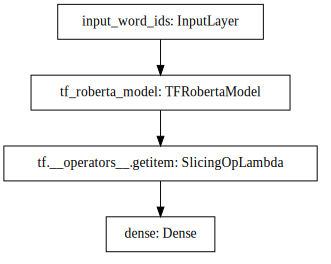

In [30]:
SVG(model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

##### Model training

In [31]:
N_STEPS = x_train.shape[0] // BATCH_SIZE

In [32]:
 # Checkpoint: save the models that show improvements in accuracy
# checkpoint_path = "./"
# filepath= checkpoint_path + "model_best_9.hdf5" #crapa cu toate
# filepath= checkpoint_path #crapa cu toate
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Early stopping: don't keep training if the validation accuracy did not improve for the last 5 epochs
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5,restore_best_weights=True)  #crapa cand da restore pe roberta large      
# es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) #early stopping fara saving
# es = EarlyStopping(monitor='loss', mode='max', verbose=1, patience=3)  
# Use the above two as callbacks
# callbacks_list = [checkpoint, es]
callbacks_list = es

In [33]:
train_history = model.fit(train_ds, steps_per_epoch = N_STEPS, validation_data = validation_ds, epochs = EPOCHS, callbacks=[callbacks_list]) #autostop
# train_history = model.fit(train_ds, steps_per_epoch = N_STEPS, validation_data = validation_ds, epochs = EPOCHS)

Epoch 1/50
276/276 [==============================] - 433s 959ms/step - loss: 1.0346 - accuracy: 0.5548 - auc: 0.7228 - val_loss: 0.6495 - val_accuracy: 0.7173 - val_auc: 0.8847
Epoch 2/50
276/276 [==============================] - 235s 850ms/step - loss: 0.6370 - accuracy: 0.7391 - auc: 0.8913 - val_loss: 0.4897 - val_accuracy: 0.7973 - val_auc: 0.9358
Epoch 3/50
276/276 [==============================] - 235s 851ms/step - loss: 0.4662 - accuracy: 0.8098 - auc: 0.9417 - val_loss: 0.3440 - val_accuracy: 0.8611 - val_auc: 0.9676
Epoch 4/50
276/276 [==============================] - 235s 851ms/step - loss: 0.2878 - accuracy: 0.8859 - auc: 0.9775 - val_loss: 0.3519 - val_accuracy: 0.8704 - val_auc: 0.9684
Epoch 5/50
276/276 [==============================] - 235s 851ms/step - loss: 0.1736 - accuracy: 0.9347 - auc: 0.9913 - val_loss: 0.1536 - val_accuracy: 0.9448 - val_auc: 0.9924
Epoch 6/50
276/276 [==============================] - 235s 851ms/step - loss: 0.1179 - accuracy: 0.9570 - auc:

##### Prediction

In [34]:
sns.set(style="whitegrid")

def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(20, 18))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
def plot_aur_curve(y_valid, valid_pred):
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_pred)
    roc_auc_valid = auc(fpr_valid, tpr_valid)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_valid, tpr_valid, color='purple', label='ValidationAUC = %0.2f' % roc_auc_valid)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_confusion_matrix(y_valid, valid_pred, labels=[0, 1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    validation_cnf_matrix = confusion_matrix(y_valid, valid_pred)

    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

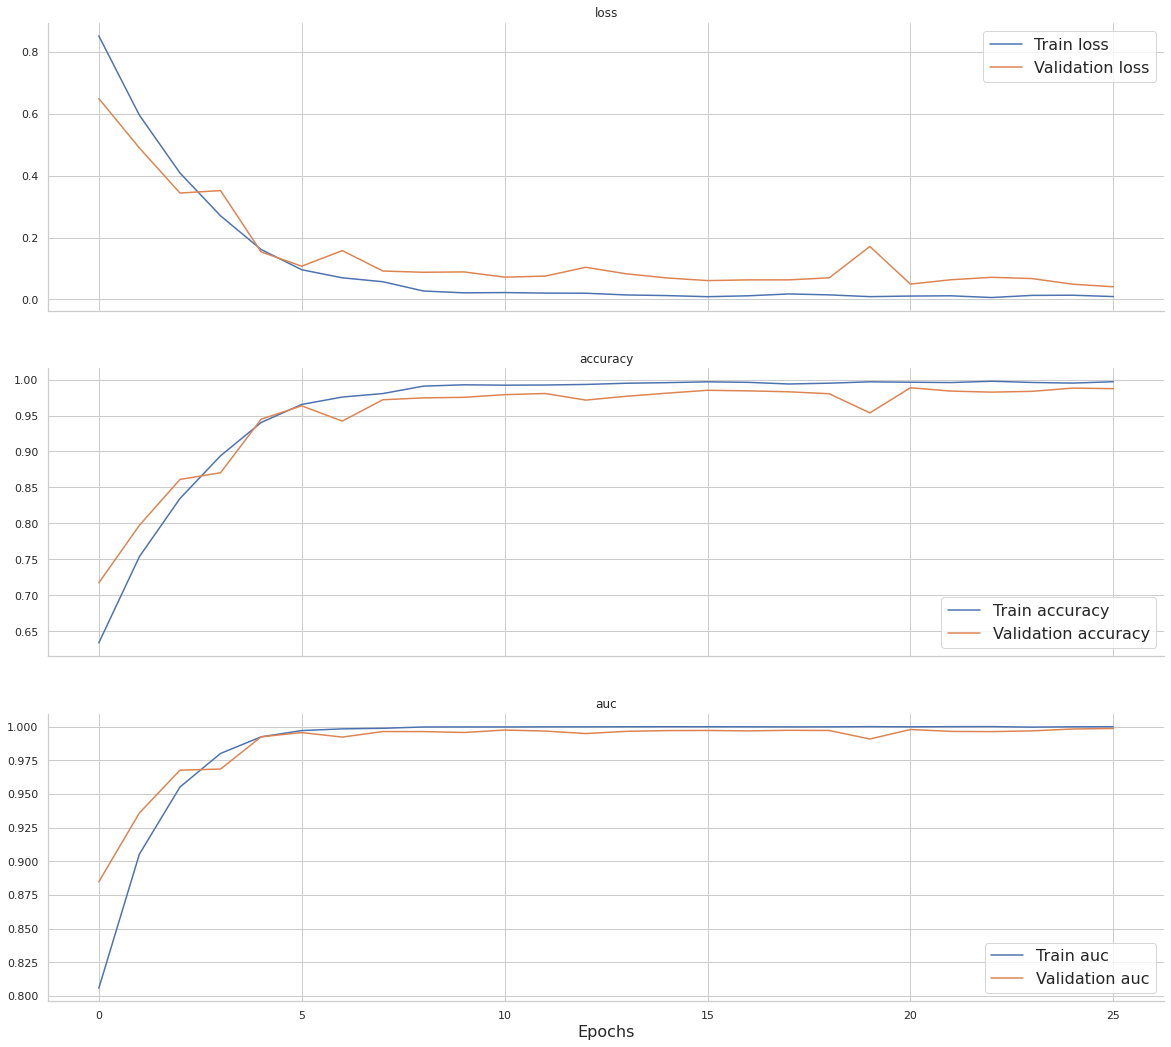

In [35]:
plot_metrics(train_history.history, metric_list=['loss', 'accuracy', 'auc'])

In [36]:
validation_pred = model.predict(validation_ds)

In [37]:
# plot_aur_curve(y_validation, validation_pred)

In [38]:
# model.predict(test_ds, verbose = 1)

In [39]:
# submission['label'] = model.predict(test_ds, verbose = 1)
predictions=np.argmax(model.predict(test_ds, verbose = 1),axis=1)
# final_prediction_list = le.inverse_transform(np.concatenate(predictions))
# final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))
# final_prediction_list = le.inverse_transform()
final_truelabel_list = le.inverse_transform(predictions)
submission['label'] = final_truelabel_list

109/109 [==============================] - 51s 409ms/step


In [40]:
submission.to_csv('submission_44.csv', index=False)

In [41]:
from IPython.display import FileLink
FileLink('submission_44.csv')

/kaggle/working/submission_44.csv

Text(66.5, 0.5, 'Predicted Dialect Label')

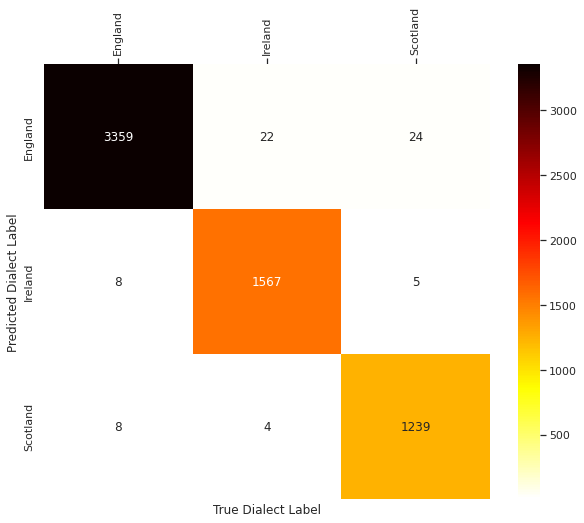

In [42]:
class_label = np.unique(le.inverse_transform(y_confusionmat))
val_pred_confusion=np.argmax(validation_pred,axis=1)
# get confusion matrix 
cm = confusion_matrix(le.inverse_transform(y_confusionmat),
                      le.inverse_transform(val_pred_confusion))
# covert it to dataframe for plotting
cm_df = pd.DataFrame(cm, 
                     index = class_label, 
                     columns = class_label)
# plot it 
plt.figure(figsize = (10,8))
g = sns.heatmap(cm_df, cmap = 'hot_r', annot=True, fmt='g')
g.xaxis.set_ticks_position("top")
g.tick_params(axis='x', rotation=90)
g.set_xlabel("True Dialect Label")
g.set_ylabel("Predicted Dialect Label")

In [43]:
print('Validation set ROC AUC %.4f' % roc_auc_score(y_validation, validation_pred))
print(classification_report(y_validation, np.round(validation_pred)))
# print(classification_report(y_validation,  np.round(validation_pred)))

Validation set ROC AUC 0.9993
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3405
           1       0.98      0.99      0.99      1580
           2       0.98      0.99      0.98      1251

   micro avg       0.99      0.99      0.99      6236
   macro avg       0.99      0.99      0.99      6236
weighted avg       0.99      0.99      0.99      6236
 samples avg       0.99      0.99      0.99      6236



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Сохраняем модель

In [44]:
# model.save_pretrained("./data/mbert_model_12")